# Predicting House Sale Prices

### Introduction

In this project we will apply the linear regression model to predict house sale prices from the citiy of Ames, Iowa, from 2006 to 2010. More about the dataset can be read [here](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf) and [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

The project will be done in 4 steps, where we first read the data, process the columns from the dataset, select the best features for the model and finally, makes the predictions and evaluates the model error. The model error will be evaluated by the average RMSE using a 5-fold cross validation.

After applying all the steps, the best model retained 19 variables and had an average RMSE of 24,168. The 19 retained variables are: Overall Qual, Gr Liv Area, Exter Qual, Kitchen Qual, Bsmt Qual, 1st Flr SF, Full Bath, Garage Area, Total Bsmt SF, Years since remodel, Fireplaces, TotRms AbvGrd, Year Built, Mas Vnr Area, Years when Sold, Foundation, Lot Shape, Bsmt Exposure and BsmtFin SF 1.

### 1 - Reading the data

In [151]:
import pandas as pd
import numpy as np

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")

### 2 - Processing the features

In this step, we will process the columns, in 4 steps:

- Creating new columns by combinating and processing columns
- Removing the columns that leak information (columns that wouldn't be available at the time)
- Removing the columns that ren't useful for ML purposes
- Removing the columns with a significant number of missing rows and replacing missing values for other columns

#### Creating new columns

In [152]:
### Creating new columns by combinating and processing columns

df['Years when Sold'] = df['Yr Sold'] - df['Year Built']
df['Years since remodel'] = df['Yr Sold'] - df['Year Remod/Add']

df = df[df['Years when Sold'] > 0] # Removing rows with negative values
df = df[df['Years since remodel'] > 0] # Removing rows with negative values


#### Dropping columns that leak informations or aren't useful

In [153]:
## Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold", "Year Remod/Add"], axis=1)

## Drop redundant columns (same information)
df = df.drop(["Garage Cars"], axis=1) # Same as Garage Area

#### Dealing with missing values

In [154]:
df.isnull().sum().value_counts().sort_index()

0       50
1        6
2        2
12       2
80       3
81       1
82       1
152      1
154      4
484      1
1330     1
2119     1
2506     1
2584     1
2677     1
dtype: int64

Firstly, we will remove all columns with more than 5% of missing values.

In [155]:
threshold = 0.05 * len(df)
null_counts = df.isnull().sum()
columns_to_remove = null_counts[null_counts > threshold].index
df = df.drop(columns_to_remove, axis=1)

In [156]:
df.isnull().sum().value_counts().sort_index()

0     50
1      6
2      2
12     2
80     3
81     1
82     1
dtype: int64

Then, we will replace the rest of missing values by the most common value (mode) of each column.

In [157]:
replacement_value = df.mode().to_dict(orient='records')[0]
df = df.fillna(replacement_value)

In [158]:
df.isnull().sum().value_counts().sort_index()

0    65
dtype: int64

### 3 - Selecting features

#### Numerical columns

The first step we will take is to calculate the correlation between each numerical column and the Sale Price. With this, we will set a threshold and remove the variables above. After, we will generate a heatmap for the remaining columns so we can find correlations between variables and remove them.

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

numerical_cols = df.select_dtypes(include=['int', 'float']).columns
correlations = df[numerical_cols].corr()['SalePrice'].abs().sort_values()
columns_to_remove = correlations[correlations < 0.4].index
df = df.drop(columns_to_remove, axis=1)
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
df[numerical_cols].corr()['SalePrice'].abs().sort_values()

BsmtFin SF 1           0.450672
Mas Vnr Area           0.469301
TotRms AbvGrd          0.476159
Fireplaces             0.488419
Years since remodel    0.515419
Years when Sold        0.538845
Year Built             0.539103
Full Bath              0.541690
Garage Area            0.608802
1st Flr SF             0.623102
Total Bsmt SF          0.632745
Gr Liv Area            0.724094
Overall Qual           0.785137
SalePrice              1.000000
Name: SalePrice, dtype: float64

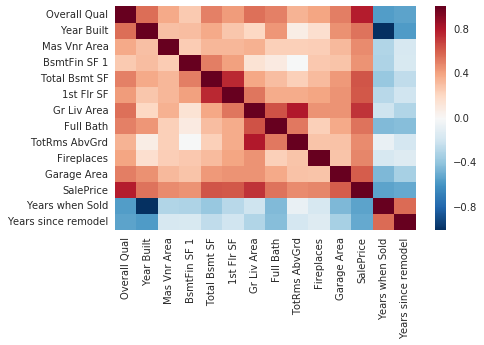

In [160]:
sns.heatmap(df[numerical_cols].corr())

There's not much correlation for the numerical columns, so we will keep those columns.

#### Categorical columns

For the remaining object columns, we will look at each one to see if how many different values they contain and what is the distribuition between those values, so we can choose what columns to remain in the model.

In [165]:
categ_columns = df.select_dtypes(include=['object']).columns
categorical_feat = pd.DataFrame(categ_columns, columns=['variable'])
size_list = []
perc_one_list = []
perc_two_list = []
for i in range(len(categorical_feat)):
    feature = categorical_feat.iloc[i][0]
    size = len(df[feature].value_counts())
    percentage_one = df[feature].value_counts(normalize=True)[0]
    percentage_two = percentage_one + df[feature].value_counts(normalize=True)[1]
    size_list.append(size)
    perc_one_list.append(percentage_one)
    perc_two_list.append(percentage_two)

categorical_feat['elements'] = size_list
categorical_feat['percentage_first_element'] = perc_one_list
categorical_feat['percentage_second_element'] = perc_two_list
categorical_feat

,variable,elements,percentage_first_element,percentage_second_element
0,MS Zoning,7,0.774266,0.942730
1,Lot Shape,4,0.643362,0.969134
2,Lot Config,5,0.727780,0.904797
3,Neighborhood,28,0.164001,0.252138
4,House Style,8,0.494980,0.787282
5,Exterior 1st,16,0.313499,0.477129
6,Exterior 2nd,16,0.309781,0.470807
7,Mas Vnr Type,5,0.625511,0.928226
8,Exter Qual,4,0.660840,0.965787
9,Foundation,6,0.459279,0.861659


We will keep only the columns that have less than 80% of the rows in the first element.

In [166]:
categorical_feat = categorical_feat[categorical_feat['percentage_first_element'] < 0.8]
#categorical_feat = categorical_feat[categorical_feat['elements'] < 10]
#categorical_feat = categorical_feat[categorical_feat['percentage_second_element'] < 0.9]

categorical_feat

,variable,elements,percentage_first_element,percentage_second_element
0,MS Zoning,7,0.774266,0.942730
1,Lot Shape,4,0.643362,0.969134
2,Lot Config,5,0.727780,0.904797
3,Neighborhood,28,0.164001,0.252138
4,House Style,8,0.494980,0.787282
5,Exterior 1st,16,0.313499,0.477129
6,Exterior 2nd,16,0.309781,0.470807
7,Mas Vnr Type,5,0.625511,0.928226
8,Exter Qual,4,0.660840,0.965787
9,Foundation,6,0.459279,0.861659


In [167]:
columns_to_keep = list(categorical_feat['variable'])
columns_to_remove = list(categ_columns)
for column in columns_to_keep:
    columns_to_remove.remove(column)

df = df.drop(columns_to_remove, axis=1)

In [168]:
len(df.columns)

29

There remained 28 features in the dataset (29 columns, one which is the SalePrice), and 14 of them are categorical and should be transformed to dummies when using linear regression.

#### Ranking the features

Before using the features to predict the house sale prices, we will rank them. This rank will be done by using only these feature for predicting the sale price and returning the RMSE. The variables with the lowest RMSE will be ranked higher.

This RMSE will be estimated by a division in train and test (75%/25%).

In [169]:
len(df)*0.75

2016.75

In [170]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

target = ['SalePrice']
rmse_dict = {}
features = list(df.columns)
features.remove('SalePrice')

for col in features:
    columns = [col, 'SalePrice']
     
    temp_df = pd.DataFrame(df, copy=True)
    temp_df = temp_df[columns]
    temp_df = pd.get_dummies(temp_df)
    temp_train = temp_df[:2016]
    temp_test = temp_df[2016:]
    
    feat = list(temp_df.columns)
    feat.remove('SalePrice')
    
    lr = LinearRegression()
    lr.fit(temp_train[feat], temp_train[target])
    
    predictions = lr.predict(temp_test[feat])
    rmse = np.sqrt(mean_squared_error(predictions, temp_test[target]))
    
    rmse_dict[col] = rmse

In [171]:
rmse_dict

{'1st Flr SF': 55786.07641910812,
 'Bsmt Exposure': 63227.02168381762,
 'Bsmt Qual': 55161.37528941975,
 'BsmtFin SF 1': 63308.24342308449,
 'BsmtFin Type 1': 65506.9801713254,
 'Exter Qual': 53737.08482982148,
 'Exterior 1st': 1.2664874199826304e+16,
 'Exterior 2nd': 67410.93485694124,
 'Fireplaces': 59692.52976212687,
 'Foundation': 61865.236256129705,
 'Full Bath': 56445.88662750933,
 'Garage Area': 57221.53815036969,
 'Gr Liv Area': 45953.676744107055,
 'Heating QC': 63632.677337276604,
 'House Style': 64559.80044549134,
 'Kitchen Qual': 54210.05662263892,
 'Lot Config': 66993.19911072432,
 'Lot Shape': 62972.7069541066,
 'MS Zoning': 64177.600674189205,
 'Mas Vnr Area': 61032.88881732326,
 'Mas Vnr Type': 7014175644959645.0,
 'Neighborhood': 3.0280395402380584e+16,
 'Overall Qual': 43900.84318930496,
 'TotRms AbvGrd': 60492.9611408133,
 'Total Bsmt SF': 57456.506144578874,
 'Year Built': 60894.38935519616,
 'Years since remodel': 58776.5828434638,
 'Years when Sold': 61107.1892352

In [172]:
variables_df = pd.DataFrame.from_dict(rmse_dict, orient='index')
variables_df['RMSE'] = variables_df[0]
variables_df = variables_df.drop(0, axis=1)
sorted_df = variables_df['RMSE'].sort_values()
sorted_df

Overall Qual           4.390084e+04
Gr Liv Area            4.595368e+04
Exter Qual             5.373708e+04
Kitchen Qual           5.421006e+04
Bsmt Qual              5.516138e+04
1st Flr SF             5.578608e+04
Full Bath              5.644589e+04
Garage Area            5.722154e+04
Total Bsmt SF          5.745651e+04
Years since remodel    5.877658e+04
Fireplaces             5.969253e+04
TotRms AbvGrd          6.049296e+04
Year Built             6.089439e+04
Mas Vnr Area           6.103289e+04
Years when Sold        6.110719e+04
Foundation             6.186524e+04
Lot Shape              6.297271e+04
Bsmt Exposure          6.322702e+04
BsmtFin SF 1           6.330824e+04
Heating QC             6.363268e+04
MS Zoning              6.417760e+04
House Style            6.455980e+04
BsmtFin Type 1         6.550698e+04
Lot Config             6.699320e+04
Exterior 2nd           6.741093e+04
Mas Vnr Type           7.014176e+15
Exterior 1st           1.266487e+16
Neighborhood           3.028

### 4 - Predicting and evaluating model error

In the last step, we ordered the 28 variables according to their RMSE. Now, we will iterate trough each number of variables (from 1 to 29) and collecting the RMSE for each quantity. The RMSE will be estimated by using a 5-fold cross validation.

In [139]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

features_list = list(sorted_df.index)
avg_rmse_list = []

for i in range(1, len(features_list)+1):
    features = features_list[:i]
    temp_df = pd.DataFrame(df, copy=True)
    train = temp_df[features]
    train = pd.get_dummies(train)
    test = temp_df['SalePrice']
    
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    model = LinearRegression()

    mses = cross_val_score(model, train, test, scoring='neg_mean_squared_error', cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    avg_rmse_list.append(avg_rmse)
    


In [148]:
for i in range(1, len(features_list) + 1):
    print(str(i) + ': ' + str(avg_rmse_list[i - 1]))

1: 44350.80272046152
2: 36901.42944031959
3: 34340.46533830282
4: 33302.2659791633
5: 31526.569091380305
6: 29673.325533130293
7: 29558.938578061905
8: 28848.91821886719
9: 28158.87321969201
10: 27885.922349653392
11: 27361.054711990048
12: 27198.204442744805
13: 26795.440394639398
14: 26657.61679359919
15: 26641.189114949328
16: 26606.410041624546
17: 26410.85316478015
18: 25893.221476201223
19: 25168.521360673658
20: 25040.935541864656
21: 24787.50154821673
22: 24761.84788857273
23: 24808.24760683097
24: 24751.31389384578
25: 24933.335056430882
26: 24760.915813456868
27: 25294.699261246882
28: 24219.561274165575


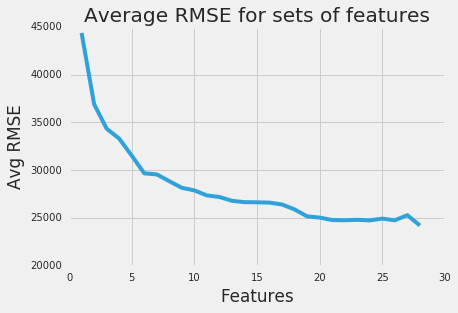

In [142]:
plt.style.use('fivethirtyeight')

y = avg_rmse_list
x = [i for i in range(1, len(features_list) + 1)]
plt.plot(x,y)
plt.title("Average RMSE for sets of features")
plt.xlabel('Features')
plt.ylabel("Avg RMSE")

### Conclusion

The lowest error (24,219) was obtained when using all the 28 variables. But using 19 variables, we obtained an average RMSE of 25,168, an error 3.9% higher with 68% of the variables. So, for purposes of model simplicity and reducing overfitting, we will define the best model as the one with 19 variables.

Those selected variables are: Overall Qual, Gr Liv Area, Exter Qual, Kitchen Qual, Bsmt Qual, 1st Flr SF, Full Bath, Garage Area, Total Bsmt SF, Years since remodel, Fireplaces, TotRms AbvGrd, Year Built, Mas Vnr Area, Years when Sold, Foundation, Lot Shape, Bsmt Exposure and BsmtFin SF 1.

